In [1]:
import os
import sys
import glob
import torch
import numpy as np
import polars as pl
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from matplotlib.lines import Line2D

np.random.seed(seed=1)

In [2]:
from ProgressDBar import ProgressTrain
from code.dtw_soft import soft_dtw_batch_same_size

#### Data Import

In [3]:
scaler = MinMaxScaler()

train = scaler.fit_transform(pl.read_csv(source='../archive/train_df.csv'))
test = scaler.transform(pl.read_csv(source='../archive/validation_df.csv'))
test_label = pl.read_csv(source='../archive/dfvalid_groundtruth.csv')

In [4]:
percentage_ones = test_label['anomaly'].mean() * 100
print("Nb Signals train         :",train.shape[0])
print("Nb Signals test          :",test.shape[0])
print("Input Dim                :",train.shape[1])
print("Test Anomaly pourcentage :",percentage_ones)
i = 0

Nb Signals train         : 1677
Nb Signals test          : 594
Input Dim                : 61441
Test Anomaly pourcentage : 50.0


#### Data Preprocessing
No further preprocessing was conducted, although it may be sensible when working with accelerator data [...].

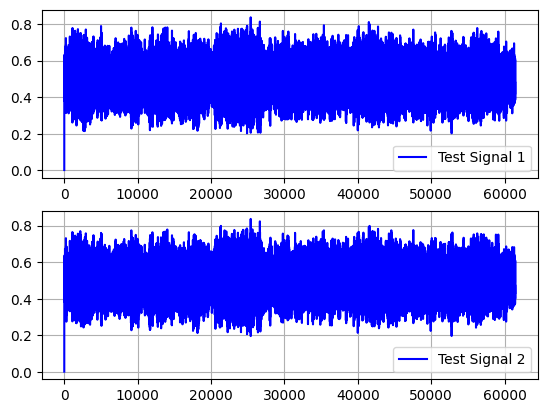

In [5]:
i += 2

color_1 = 'red' if test_label['anomaly'][i] == 1 else 'blue'
color_2 = 'red' if test_label['anomaly'][i + 1] == 1 else 'blue'

plt.subplot(2, 1, 1)
plt.plot(test[i, :], label='Test Signal 1', color=color_1)
plt.legend()
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(test[i + 1, :], label='Test Signal 2', color=color_2)
plt.legend()
plt.grid()

plt.show()

#### PyTorch Dataset Implementation

In [6]:
class SensorDataset(Dataset):

    def __init__(self, dataset: np.array, split = 10,label = None):
        self.dataset = dataset
        self.split = split
        self.label = label

        signal_length = len(self.dataset[0])
        print("Signal Len :",signal_length // self.split,(signal_length // self.split)%16)

    def __len__(self):
        return len(self.dataset) * 5

    def __getitem__(self, index):
        signal_index = index // self.split
        split_index = index % self.split
        signal_length = len(self.dataset[signal_index])
        split_length = signal_length // self.split
        start = split_index * split_length
        end = start + split_length

        if self.label is None:
            return torch.FloatTensor(self.dataset[signal_index][start:end])
        else:
            return torch.FloatTensor(self.dataset[signal_index][start:end]), self.label['anomaly'][signal_index]


#### PyTorch Progress Bar Implementation

In [7]:
test_dataset = SensorDataset(train)

Signal Len : 6144 0


In [8]:
test_dataset[2].shape

torch.Size([6144])

## Autoencoder
#### AE: Pytorch Lightning Model Implementation
Implementation of a plain Autoencoder

In [9]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        # Encoding layers
        self.conv1 = nn.Conv1d(1, 16, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv1d(16, 32, kernel_size=3, stride=2, padding=1)  # Increased output channels
        self.conv3 = nn.Conv1d(32, 64, kernel_size=3, stride=2, padding=1)  # Output channels = hidden_size
        self.conv4 = nn.Conv1d(64, 128, kernel_size=3, stride=2, padding=1)  # New layer
        self.encoder_lstm = nn.LSTM(128, 128, 1, batch_first=True)

        # Decoding layers
        self.decoder_lstm = nn.LSTM(128, 128, 1, batch_first=True)
        self.deconv1 = nn.ConvTranspose1d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1)  # New layer
        self.deconv2 = nn.ConvTranspose1d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.deconv3 = nn.ConvTranspose1d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.deconv4 = nn.ConvTranspose1d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1)

    def forward(self, x):
        # Encoding
        x = x.unsqueeze(1)  # Add channel dimension
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = x.transpose(1, 2)  # LSTM expects input as (batch, seq_len, features)
        _, (hidden, cell) = self.encoder_lstm(x)

    
        # Decoding
        decoder_input = hidden[-1].unsqueeze(1).repeat(1, x.size(1), 1)
        decoded, _ = self.decoder_lstm(decoder_input, (hidden, cell))
        decoded = decoded.transpose(1, 2)
        decoded = F.relu(self.deconv1(decoded))
        decoded = F.relu(self.deconv2(decoded))
        decoded = F.relu(self.deconv3(decoded))
        decoded = F.relu(self.deconv4(decoded))
        decoded = decoded.squeeze(1)  # Remove channel dimension

        return decoded


In [10]:
total_params = 0
for name, param in Autoencoder().named_parameters():
    num_params = param.numel()
    total_params += num_params
    print(f"{name:<30} | Number of Parameters: {num_params}")

# Print total parameters in bold
print(f"\033[1mTotal Number of Parameters: {total_params}\033[0m")

test_model = Autoencoder()
out = test_model(torch.ones((1,608)))
print(torch.mean(out),torch.var(out))

conv1.weight                   | Number of Parameters: 48
conv1.bias                     | Number of Parameters: 16
conv2.weight                   | Number of Parameters: 1536
conv2.bias                     | Number of Parameters: 32
conv3.weight                   | Number of Parameters: 6144
conv3.bias                     | Number of Parameters: 64
conv4.weight                   | Number of Parameters: 24576
conv4.bias                     | Number of Parameters: 128
encoder_lstm.weight_ih_l0      | Number of Parameters: 65536
encoder_lstm.weight_hh_l0      | Number of Parameters: 65536
encoder_lstm.bias_ih_l0        | Number of Parameters: 512
encoder_lstm.bias_hh_l0        | Number of Parameters: 512
decoder_lstm.weight_ih_l0      | Number of Parameters: 65536
decoder_lstm.weight_hh_l0      | Number of Parameters: 65536
decoder_lstm.bias_ih_l0        | Number of Parameters: 512
decoder_lstm.bias_hh_l0        | Number of Parameters: 512
deconv1.weight                 | Number of Param

#### AE Model Training

In [11]:
class EarlyStopping:
    def __init__(self, patience=5):
        self.patience = patience
        self.counter = 0
        self.best_score = None
        self.early_stop = False

    def __call__(self, val_accuracy):
        score = val_accuracy

        if self.best_score is None:
            self.best_score = score
        elif score <= self.best_score:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0

In [16]:
model = Autoencoder()
batch_size = 16

ae_train, ae_valid = train_test_split(train, test_size = 0.15, random_state=1, shuffle=True)
ae_train_ds, ae_val_ds = SensorDataset(ae_train,split=202), SensorDataset(ae_valid,split=202)
ae_tdl, ae_vdl = DataLoader(ae_train_ds, batch_size=batch_size), DataLoader(ae_val_ds, batch_size=batch_size)

es = EarlyStopping(patience=3)
#dsdsqd

max_epoch = 10
learning_rate = 0.03
optimizer = torch.optim.Adam(model.parameters(),lr = 0.003)

device = "cpu"
model.to(device)
save_model = "models/Model_MSE" + ".pt"

loss = nn.MSELoss()
name_list = ["Train Loss","Test Loss","Autre1","Autre2"]


print("="*20," Data  Infos ","="*20)
print("Train Dataloader Len :",len(ae_tdl))
print("Valid Dataloader Len :",len(ae_vdl))
print("Batch size           :",batch_size)
print()
print("="*20," Train Infos ","="*20)
print("Max Epoch            :",max_epoch)
print("Early Stopping       :",5)
print("Optimizer            :","Adam")
print("Learning Rate        :",learning_rate)
print("Device               :",device)
print("Save model path      :",save_model)
print()
print("="*20," Loss  Infos ","="*20)
print("Loss                 :","MSE")
print("Tracked parametres   :",name_list)


Signal Len : 304 0
Signal Len : 304 0
====================  Data  Infos  ====================
Train Dataloader Len : 446
Valid Dataloader Len : 79
Batch size           : 16

====================  Train Infos  ====================
Max Epoch            : 3
Early Stopping       : 5
Optimizer            : Adam
Learning Rate        : 0.03
Device               : cpu
Save model path      : Model_MSE.pt

====================  Loss  Infos  ====================
Loss                 : MSE
Tracked parametres   : ['Train Loss', 'Test Loss', 'Autre1', 'Autre2']


In [17]:
def TRAIN():
    try:
        P = ProgressTrain(len(ae_tdl),num_update=100,names = name_list)
        loss_hist = []
        for epoch in range(max_epoch):

            model.train()  # Set the model to training mode

            for x in ae_tdl:
                x = x.to(device)

                optimizer.zero_grad()

                x_predicted = model(x)

                l = loss(x_predicted, x)
                l.backward()
                optimizer.step()

                # Log training loss
                loss_hist.append(l.item())

                P.Update([l.item(),epoch])



            model.eval()  # Set the model to evaluation mode
            with torch.no_grad():
                total_loss_valid = 0
                for x in ae_vdl:
                    x = x.to(device)
                    x_predicted = model(x)
                    l = loss(x_predicted, x)
                    total_loss_valid += l.item()


            mean_loss_train = np.sum(np.array(loss_hist)[-len(ae_tdl):])/len(ae_tdl)
            mean_loss_valid = total_loss_valid/len(ae_vdl)

            P.End([mean_loss_train,mean_loss_valid,1,1])

            es(mean_loss_valid)

            if es.best_score == mean_loss_valid:
                torch.save(model, save_model)

            if es.early_stop:
                print("Early stopping triggered")
                break

        P.plot_data_by_names(["Train Loss","Test Loss"])
            
    except KeyboardInterrupt:
        torch.save(model, save_model)
        print("Training interrupted and model saved.")
        P.plot_data_by_names(["Train Loss","Test Loss"])

[--------------------------------------------------] 0.0%    

||    ||          Loss          ||        Accuracy        ||
||    ||   Train   ||   Test    ||   Train   ||   Test    ||
||DON || 0.1363986 || 0.1365538 || 1 || 1
||DON || 0.1356034 || 0.1365462 || 1 || 1
||DON || 0.1355921 || 0.1364702 || 1 || 1


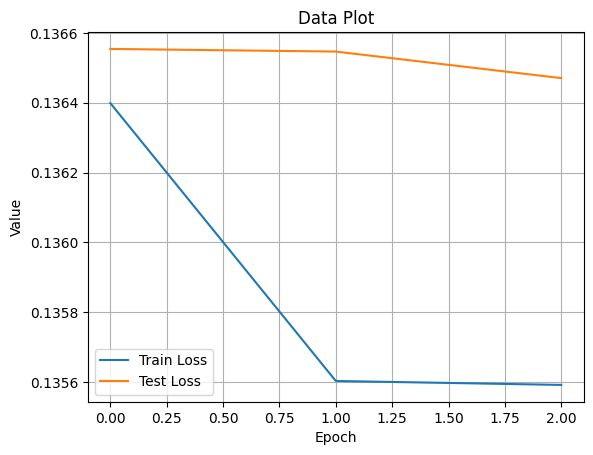

In [18]:
TRAIN()

In [19]:
gamma = 1
save_model = "models/Model_DTW" + ".pt"
def sdtw_loss(x,x_predicted):
    return torch.mean(soft_dtw_batch_same_size(x.unsqueeze(-1),x_predicted.unsqueeze(-1),gamma))
loss = sdtw_loss

In [20]:
TRAIN()

[--------------------------------------------------] 0.0%    

||    ||          Loss          ||        Accuracy        ||
||    ||   Train   ||   Test    ||   Train   ||   Test    ||


##### Best Model Retrieval (EarlyStopping)

In [ ]:
model = torch.load(save_model)

#### AE: Result Visualization

In [ ]:
test_ds = SensorDataset(test,label = test_label)
losses = []
labels = []
for i in range(len(test_ds)):
    x, lab= test_ds[i]
    x = x.to(device).unsqueeze(0)
    x_predicted = model(x)
    l = loss(x_predicted, x)
    losses.append(l.item())
    labels.append(lab)
    
label_color_mapping = {0: 'blue', 1: 'red'}
test_label_colors = np.array([label_color_mapping[label] for label in labels])

legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=label)
                   for label, color in label_color_mapping.items()]


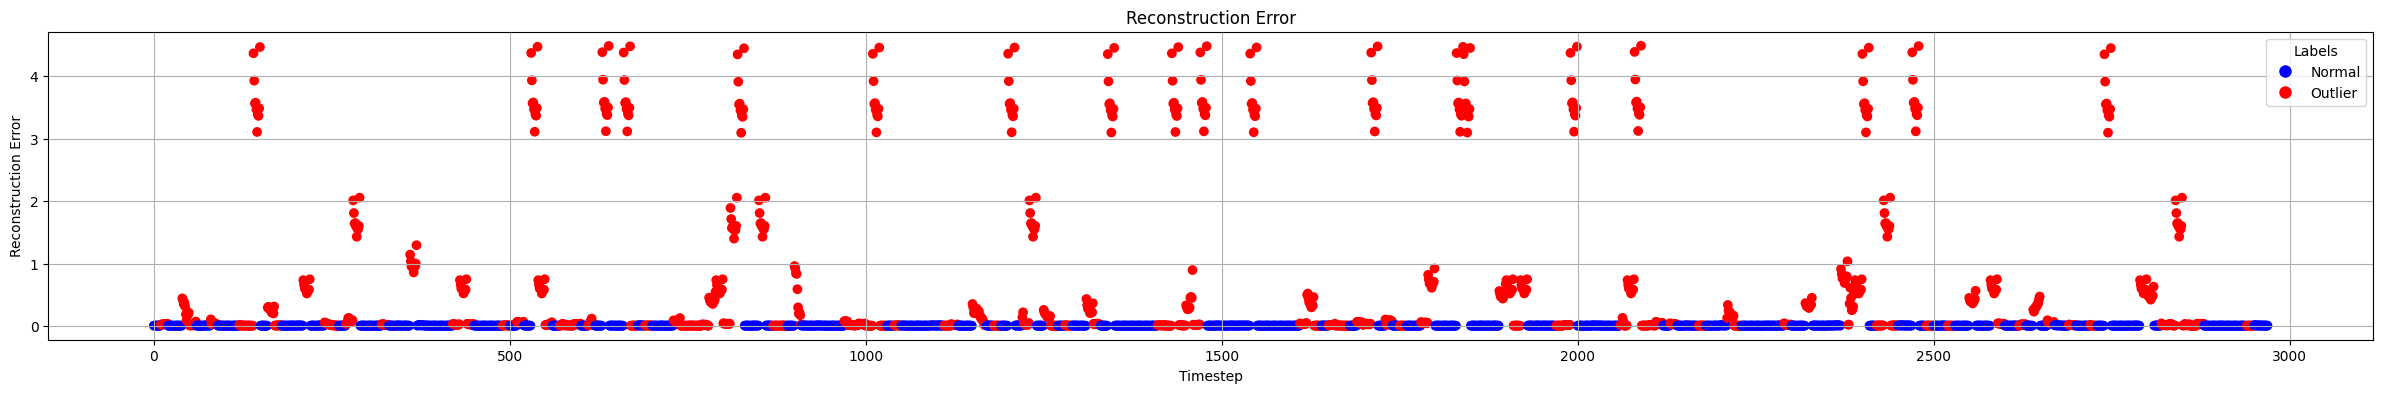

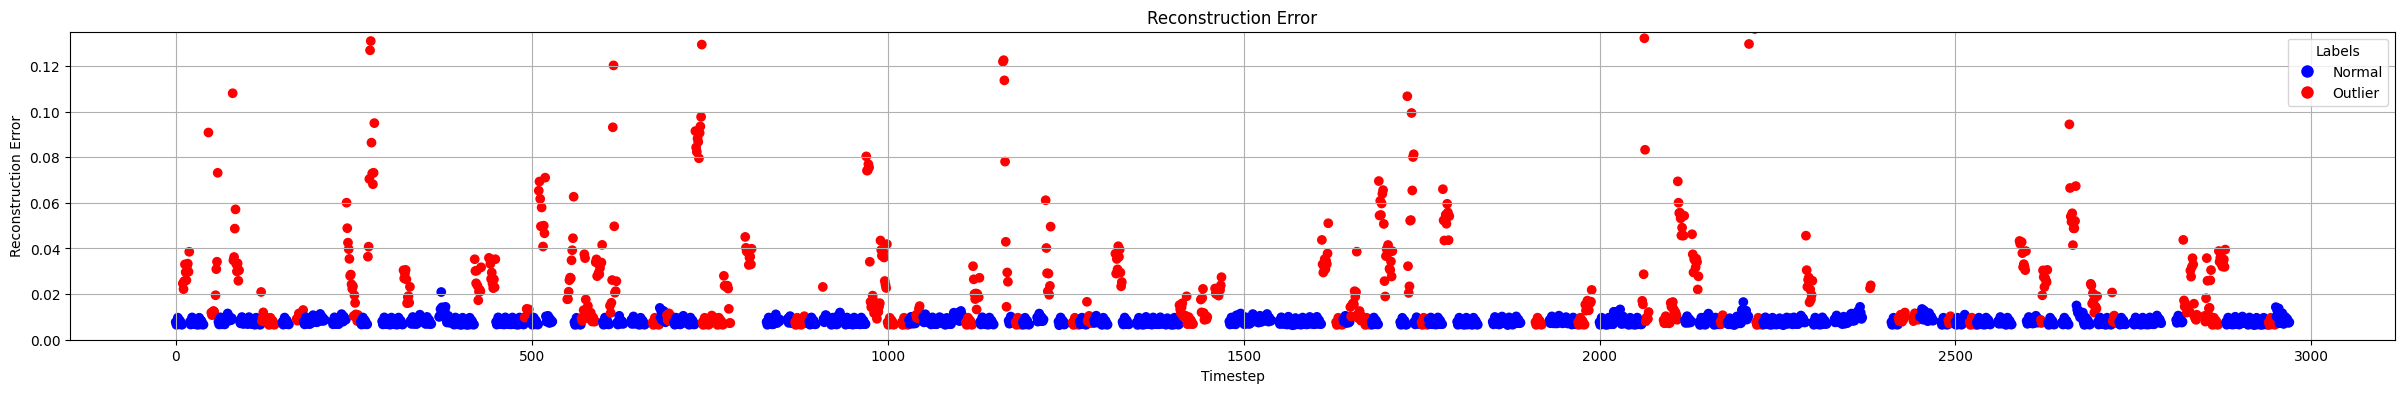

In [ ]:

# Overview
plt.figure(figsize=(30, 4))
scatter = plt.scatter(range(len(losses)), losses, label='Reconstruction Error', c=test_label_colors)
plt.xlabel('Timestep')
plt.ylabel('Reconstruction Error')
plt.title('Reconstruction Error')
plt.legend(handles=legend_elements, title='Labels', labels=['Normal', 'Outlier'])
plt.grid()
plt.show()

# Zoomed
plt.figure(figsize=(30, 4))
scatter_zoomed = plt.scatter(range(len(losses)), losses, label='Reconstruction Error', c=test_label_colors)
plt.ylim(0, np.median(losses) * 15)
plt.xlabel('Timestep')
plt.ylabel('Reconstruction Error')
plt.title('Reconstruction Error')
plt.legend(handles=legend_elements, title='Labels', labels=['Normal', 'Outlier'])
plt.grid()
plt.show()

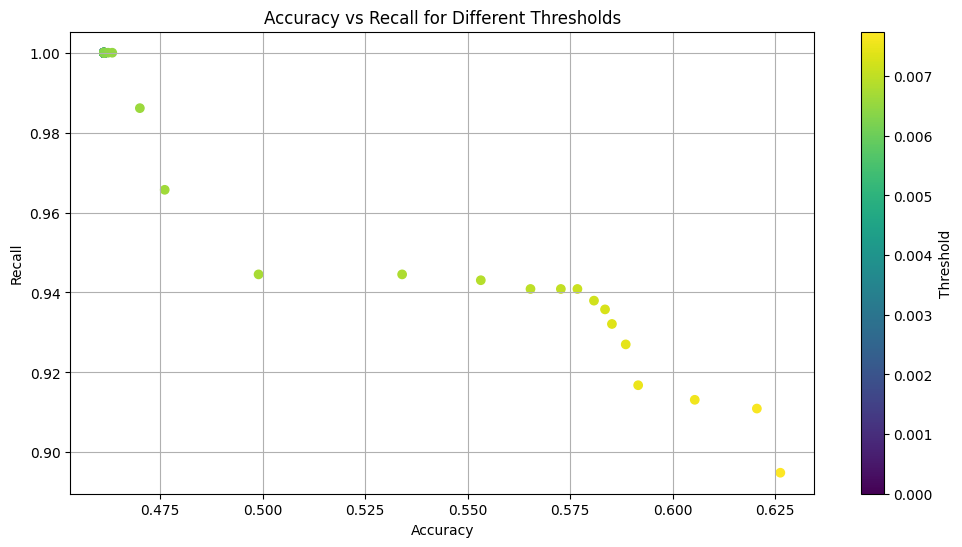

In [ ]:
from sklearn.metrics import accuracy_score, recall_score

# Assuming labels are 0 for normal and 1 for anomaly
thresholds = np.linspace(0, np.max(np.array(losses[labels==0])), 100)
accuracies = []
recalls = []

for threshold in thresholds:
    predictions = [1 if loss > threshold else 0 for loss in losses]
    accuracies.append(accuracy_score(labels, predictions))
    recalls.append(recall_score(labels, predictions))

# Scatter plot of accuracy vs recall for different thresholds
plt.figure(figsize=(12, 6))
plt.scatter(accuracies, recalls, c=thresholds, cmap='viridis')
plt.colorbar(label='Threshold')
plt.xlabel('Accuracy')
plt.ylabel('Recall')
plt.title('Accuracy vs Recall for Different Thresholds')
plt.grid()
plt.show()

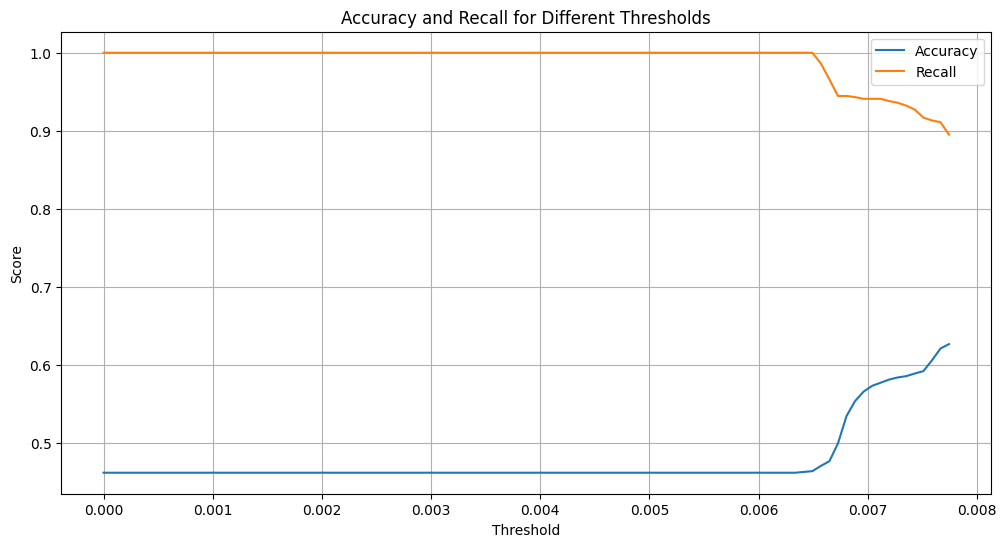

In [ ]:
# Plotting accuracy and recall for different thresholds
plt.figure(figsize=(12, 6))
plt.plot(thresholds, accuracies, label='Accuracy')
plt.plot(thresholds, recalls, label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Accuracy and Recall for Different Thresholds')
plt.legend()
plt.grid()
plt.show()